In [4]:
%pylab inline
import numpy as np
import torch
import os
import time
import pandas as pd
import nibabel as nib

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch import autograd
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data import dataloader

from sklearn.preprocessing import StandardScaler
from nilearn import plotting
from ADNI_dataset import *
from BRATS_dataset import *
from ATLAS_dataset import *
from Model_alphaWGAN import *
import pytorch_ssim
import matplotlib.pyplot as plt
from ipdb import set_trace
from utils import *

Populating the interactive namespace from numpy and matplotlib


/usr/local/miniconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['Generator', 'plotting', 'resize', 'time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Configuration

In [5]:
# used to store the MMD ans MS-SSIM
try:
    os.mkdir('./test_data')
except FileExistsError:
    pass
workers = 4
BATCH_SIZE = 8
latent_dim = 1000

Use_BRATS = False
Use_ATLAS = False
gpu = 0

In [6]:
trainset = ADNIdataset(augmentation=True)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)
#'flair' or 't2' or 't1ce'
# trainset = BRATSdataset(imgtype='flair')
# train_loader = torch.utils.data.DataLoader(trainset,batch_size = BATCH_SIZE, shuffle=True,
#                                                num_workers=workers)

# trainset = ATLASdataset(augmentation=True)
# train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
#                                           shuffle=True,num_workers=workers)

gen_load = inf_train_gen(train_loader)

## Pre-trained Generator Load

In [7]:
#-------------------------------------------
#Choose the Model you want!
from Model_alphaWGAN import *
# from Model_alphaWGAN import Discriminator
# from Model_alphaGAN import Generator
# from Model_VAEGAN import Generator
# from Model_VAEGAN import Encoder
# from Model_WGAN import Generator
#-------------------------------------------

G = Generator(noise=latent_dim).cuda(gpu)
# E = Encoder(out_class = latent_dim).cuda(gpu)
E = Discriminator(out_class = latent_dim, is_dis=False).cuda(gpu)
#-----------------------
#Load Pre-trained model
#-----------------------

#------------Trained Model of ADNI dataset---------------------
# G.load_state_dict(torch.load('./checkpoint/G_iter188500.pth')) # Alpha-WGAN-GP
# E.load_state_dict(torch.load('./trained/E_iter12500.pth')) # Alpha-WGAN-GP Encoder
# G.load_state_dict(torch.load('./vae_checkpoint_1/G_iter100000.pth')) #VAE-GAN
# G.load_state_dict(torch.load('./vae_checkpoint_1/G_VG_ep_100.pth')) #VAE-GAP
# G.load_state_dict(torch.load('./vae_checkpoint_gp/G_iter.pth')) #Alpha-GAN
# G.load_state_dict(torch.load('./checkpoint/G_W_iter3000.pth')) #WGAN-GP

#------------Trained Model of ATLAS dataset---------------------
# G.load_state_dict(torch.load('./checkpoint/Ours_at_G.pth'))

#------------Trained Models of BRATS dataset---------------------
# G.load_state_dict(torch.load('./checkpoint/Ours_fl_G.pth'))
# G.load_state_dict(torch.load('./checkpoint/Ours_t2_G.pth'))

Fake Image - slice series visualization

You can change the axis (x , y , z ) by changing  display_mode = 'x' / 'y' / 'z'

In [ ]:
Show_color = False

noise = torch.randn(1, latent_dim).cuda(gpu)
fake_image = G(noise)
featmask = np.squeeze(fake_image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))

arr1 = [4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
arr2 = [34,36,38,40,42,44,46,48,50,52,54,56,58,60]
if Show_color:
    disp = plotting.plot_img(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False,positions=True)
    plotting.show()
    disp=plotting.plot_img(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()
else:
    disp = plotting.plot_anat(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    plotting.show()
    # disp.annotate(size=25,left_right=False)
    disp=plotting.plot_anat(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()

Fake Image - Center cut slices Visualization

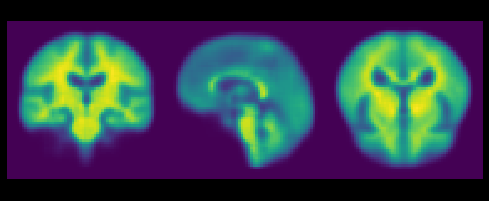

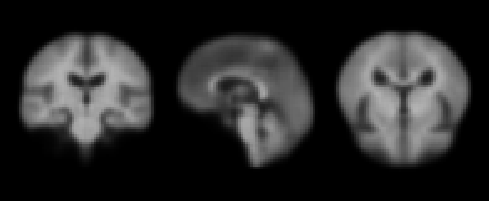

In [183]:
noise = Variable(torch.randn((1, 1000)).cuda(gpu))
# fake_image = G(noise)
featmask = np.squeeze(fake_image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
plotting.plot_img(featmask,cut_coords=(32,32,32),draw_cross=False,annotate=False,black_bg=True)
plotting.plot_anat(featmask,cut_coords=(32,32,32),draw_cross=False,annotate=False,black_bg=True)
plotting.show()

Real Image - Slice series visualization

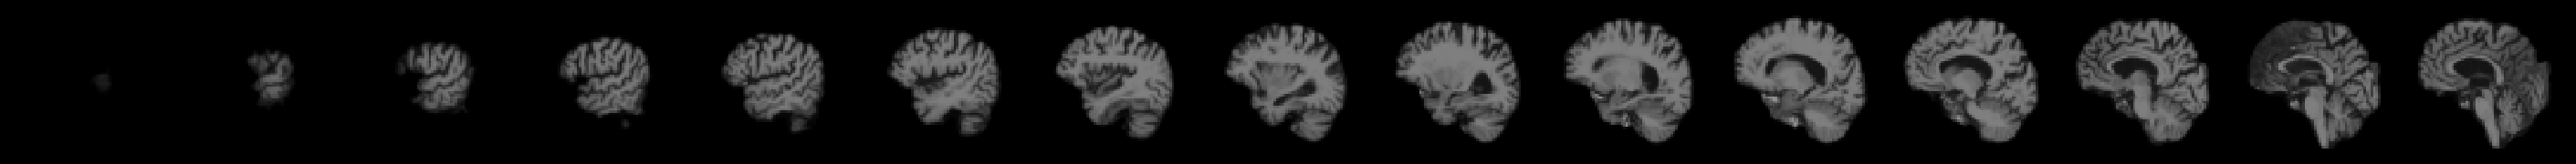

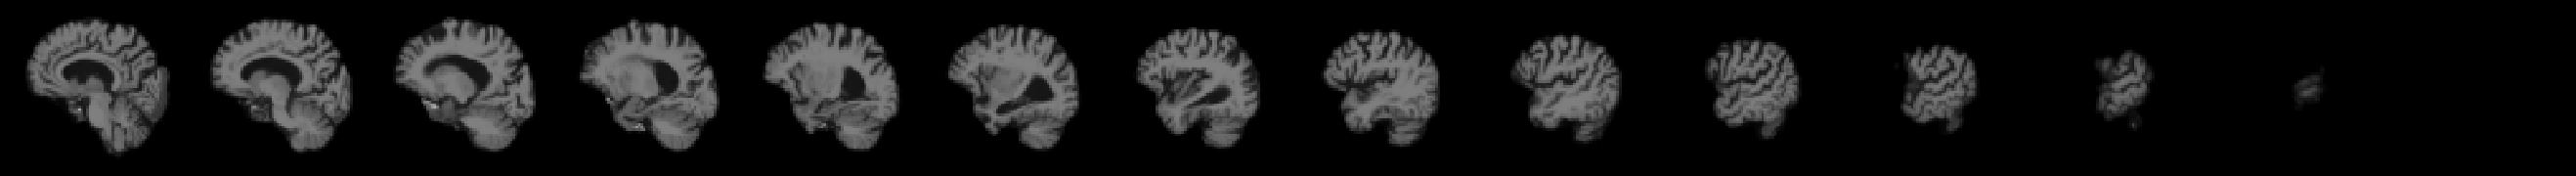

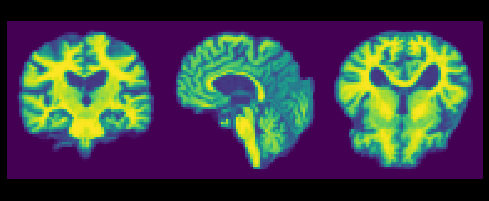

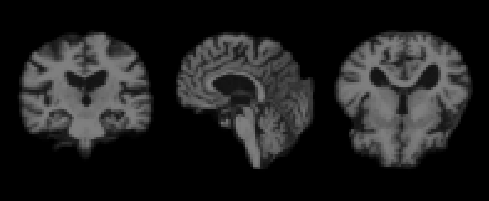

In [157]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)

Show_color = False

image = gen_load.__next__()
featmask = np.squeeze(image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
arr1 = [4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
arr2 = [34,36,38,40,42,44,46,48,50,52,54,56,58,60]

if Show_color:
    disp = plotting.plot_img(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False,positions=True)
    plotting.show()
    disp=plotting.plot_img(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()
else:
    disp = plotting.plot_anat(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    plotting.show()
    # disp.annotate(size=25,left_right=False)
    disp=plotting.plot_anat(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()

plotting.plot_img(featmask,cut_coords=(32,32,32),draw_cross=False,annotate=False,black_bg=True)
plotting.plot_anat(featmask,cut_coords=(32,32,32),draw_cross=False,annotate=False,black_bg=True)
plotting.show()

# MS-SSIM Calculation

In [ ]:
G.load_state_dict(torch.load('./mmd_checkpoint/G_iter42000.pth'))
sum_ssim = 0
for i in range(1000):
    noise = Variable(torch.randn((2, 1000)).cuda(gpu))
    images = gen_load.__next__().cuda(gpu)
#   images = G(noise)
    img1 = images[0]
    img2 = images[1]

    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    if i % 100 == 0:
        print(sum_ssim/1000)
print(f'final ssim: {sum_ssim/1000}')

# MS-SSIM Curve

In [ ]:
ssim_pth = 'alpha_checkpoint_2'
last_ind = read_ssim(path=ssim_pth)
last_ind = 1000 if not last_ind else last_ind
inds = [1000] + list(range(5000, 200001, 5000))
for i in inds[inds.index(last_ind):]:
#     G.load_state_dict(torch.load(f'./{ssim_pth}/G_VG_ep_{i}.pth'))
    G.load_state_dict(torch.load(f'./{ssim_pth}/G_iter{i}.pth'))
    calc_ssim(G, i, ssim_pth, no_write=False, gpu=gpu)

In [ ]:
%debug

# MS-SSIM for real images

In [ ]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)
test_loader = inf_train_gen(train_loader)

i = 0
sum_ssim = 0
while i < 494:
    img1, img2 = test_loader.__next__()
    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    i += 1
    if i % 100 == 0:
        print(i, sum_ssim/ (494 * 2))
        
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)
test_loader = inf_train_gen(train_loader)
while i < 494 * 2:
    img1, img2 = test_loader.__next__()
    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    i += 1
    if i % 100 == 0:
        print(i, sum_ssim/ (494 * 2))
print(sum_ssim/(494 * 2))

# Maximum-Mean Discrepancy Score

### calculate averaged mmd score

In [ ]:
mode = 'rbf'
mmd_pth = 'wl_checkpoint'
G.load_state_dict(torch.load(f'./{mmd_pth}/G_iter100000.pth')) 
for i in [1, 10, 100, 1000]:
    calc_old_mmd(train_loader, G, i, count=10, mode=mode, gpu_ind=gpu, path=mmd_pth, no_write=True, z_r=i)

### create mmd cruve

In [54]:
mode ='rbf'
mmd_pth = 'wl_checkpoint_mse_3_2'
for i in range(2000, 100000, 1000):
    i = int(i / 1000) if 'vae' in mmd_pth else i
    G.load_state_dict(torch.load(f'./{mmd_pth}/G_iter{i}.pth'))
#     G.load_state_dict(torch.load(f'./{mmd_pth}/G_VG_ep_{i}.pth'))
    calc_mmd(train_loader, G, i, count=1, gpu_ind=gpu, mode=mode, path=mmd_pth, no_write=False)


iteration: 2000, count: 0, Mean: 1.474174976348877, cost 72.01793909072876 seconds
Total_mean:1.474174976348877 STD:0.0

iteration: 3000, count: 0, Mean: 1.2433184385299683, cost 51.410226583480835 seconds
Total_mean:1.2433184385299683 STD:0.0

iteration: 4000, count: 0, Mean: 1.016890287399292, cost 47.65023922920227 seconds
Total_mean:1.016890287399292 STD:0.0

iteration: 5000, count: 0, Mean: 0.9261801242828369, cost 46.41684556007385 seconds
Total_mean:0.9261801242828369 STD:0.0


RuntimeError: CUDA out of memory. Tried to allocate 125.00 MiB (GPU 1; 10.76 GiB total capacity; 428.23 MiB already allocated; 68.12 MiB free; 405.00 KiB cached)

In [6]:
mode ='rbf'
mmd_pth = 'wl_checkpoint_mse_3'
last_ind = int(read_mmd(mmd_pth, name=f'{mode}_mmd.csv'))
end = 101000
last_ind = last_ind * 1000 if 'vae' in mmd_pth else last_ind
if not last_ind:
    inds = [1000] + list(range(5000, end, 5000))
elif last_ind == 1000:
    inds = range(5000, end, 5000)
else: 
    inds = range(last_ind + 5000, end, 5000)
for i in inds:
    i = int(i / 1000) if 'vae' in mmd_pth else i
    G.load_state_dict(torch.load(f'./{mmd_pth}/G_iter{i}.pth'))
#     G.load_state_dict(torch.load(f'./{mmd_pth}/G_VG_ep_{i}.pth'))
    calc_mmd(train_loader, G, i, count=10, gpu_ind=gpu, mode=mode, path=mmd_pth, no_write=False)


iteration: 1000, count: 0, Mean: 2.466902494430542, cost 54.87526226043701 seconds

iteration: 1000, count: 1, Mean: 2.383770227432251, cost 51.46204400062561 seconds

iteration: 1000, count: 2, Mean: 2.4438774585723877, cost 52.26940035820007 seconds

iteration: 1000, count: 3, Mean: 2.4441745281219482, cost 49.955952405929565 seconds

iteration: 1000, count: 4, Mean: 2.4284610748291016, cost 57.84153723716736 seconds

iteration: 1000, count: 5, Mean: 2.434771776199341, cost 63.24407148361206 seconds

iteration: 1000, count: 6, Mean: 2.4258639812469482, cost 75.66835522651672 seconds

iteration: 1000, count: 7, Mean: 2.4402272701263428, cost 55.64813017845154 seconds

iteration: 1000, count: 8, Mean: 2.4327619075775146, cost 49.68131446838379 seconds

iteration: 1000, count: 9, Mean: 2.4051289558410645, cost 48.91184067726135 seconds
Total_mean:2.430593967437744 STD:0.02159166022510236

iteration: 5000, count: 0, Mean: 0.8469203114509583, cost 48.998570919036865 seconds

iteration: 5

KeyboardInterrupt: 

In [ ]:
%debug

### visualize mmd curve

In [ ]:
df = load_csv('./trained/wl_gan_mmd.csv')
plt.figure()
df['mmd_score'].plot()

### T-SNE Visualization

In [8]:
tsne_pth, model = 'wl_checkpoint_mse', G
model_code = 'E' if model == E else 'G'
model.load_state_dict(torch.load(f'./{tsne_pth}/{model_code}_iter100000.pth'))
for i in [0.1]: #, 1, 10, 100, 1000, 5000, 10000]:
    start = time()
    viz_pca_tsne(model, trainset, index=i, is_cd=(model == E), is_tsne=True, latent_size=latent_dim, gpu_ind=gpu, perplexity=30, z_r=1)
    print(f'time cost: {time() - start}')

NameError: name 'z_r' is not defined

In [ ]:
%debug

### X PCA Visualization

In [ ]:
pca_pth = 'wl_checkpoint'
for i in range(100000, 0, -5000):
# for i in range(122, -1, -10):
    G.load_state_dict(torch.load(f'./{pca_pth}/G_iter{i}.pth'))
    viz_pca_tsne(G, trainset, latent_size=latent_dim, gpu_ind=gpu)

In [ ]:
def show_pca_cluster(x, PC_list, interval=3):
    for i in range(x, x+interval):
        sample_ind = PC_list[i][2]
        feat = sample_df.iloc[int(sample_ind)].to_numpy().reshape((64, 64, 64))
        featmask = nib.Nifti1Image(feat,affine = np.eye(4))
        plotting.plot_img(featmask, title=f'x_val: {round(PC_list[i][0], 2)} y_val: {round(PC_list[i][1], 2)} sample_index: {int(sample_ind)}')
        plotting.show()

# concatenate the sample index 
PC_list = list(np.concatenate((PCs, np.array([i for i in range(512)]).reshape(512, 1)), 1ghgng
# sort by x or y of PCAs
PC_list.sort(key=lambda x: x[1])

# for i in range(0, 512, 60):
#     show_pca_cluster(i, PC_list, 1)

show_pca_cluster(0, PC_list, 10)



### visualize all training images

In [ ]:
viz_all_imgs('../../ADNI', [0])

### loss check

In [ ]:
loss_df = load_loss(path='wl_checkpoint_2')
# print(loss_df)
# alpha_wgan
plt.figure(figsize=(400, 400))
loss_df[['loss2','gp_h','gp_r',]].plot() 
loss_df[['loss1','l1_loss','d_recon','d_fake','d_real','d_loss',]].plot()
loss_df[['d_recon','d_fake','l1_loss']].plot()
# vae_gan
# loss_df[['d_real_loss', 'd_fake', 'd_recon', 'err_enc']].plot() 

# plt.figure()
# # loss_df[['loss1', 'mmd_loss']].plot()
# plt.figure()
# loss_df[['gp_r', 'gp_h', 'l1_loss']].plot()

In [ ]:
%debug

### Z space pca

In [ ]:
E.load_state_dict(torch.load(f'./wl_checkpoint_mse/E_iter100000.pth'))
for i in [1, 10, 100, 1000]:
    viz_pca(E, trainset, latent_size=latent_dim, index=100000, is_cd=True, gpu_ind=gpu)

In [ ]:
%debug

In [ ]:
# for VAEGAN
for i in range(100, -1, -10):
    E.load_state_dict(torch.load(f'./vae_checkpoint_1/E_VG_ep_{i}.pth'))
    viz_pca(E, trainset, latent_size=latent_dim, index=i, is_cd=True, gpu_ind=gpu, batch_size=1)

In [ ]:
# for AlphaWGAN
for i in range(42000, 0, -2000):
    E.load_state_dict(torch.load(f'./wl_checkpoint/E_iter{i}.pth'))
    viz_pca(E, trainset, latent_size=latent_dim, index=i, is_cd=True, gpu_ind=gpu)

### delete CD and D

# Calculate the paddings of fake images

In [ ]:
G = Generator(noise=1000).cuda(gpu)
G.load_state_dict(torch.load('./trained/G_iter12500.pth'))

def get_padding(feat, axis=0):
    feat = np.swapaxes(feat, 0, axis)
    output = [0, 0]
    for i in range(feat.shape[0]):
#         print(feat[i].sum())
        if feat[i].sum() > -4000:
            output[0] = i
            break
    for i in range(feat.shape[0] - 1, -1, -1):
        if feat[i].sum() > -4000:
            output[1] = feat.shape[0] - i - 1
            break
    return output
    
for i in range(512):
    noise = torch.rand((1, 1000)).cuda(gpu)
    img = G(noise)
    featmask = np.squeeze((0.5*img+0.5).detach().cpu().numpy())
    print(f'ind: {i} padding 0-axis: {get_padding(featmask, 0)}', end=' ')
    print(f'ind: {i} padding 1-axis: {get_padding(featmask, 1)}', end=' ')
    print(f'ind: {i} padding 2-axis: {get_padding(featmask, 2)}')
#     featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
#     plotting.plot_img(featmask, title=f'ind: {i}')
#     plotting.show()

### intensity range check

In [ ]:
trainset = ADNIdataset(augmentation=True, img_size=64, normalization=False)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)
for featmask in inf_train_gen(train_loader):
#     noise = torch.rand((1, 1000)).cuda()
#     featmask= G(noise)
#     featmask = np.squeeze((0.5*featmask+0.5).detach().cpu().numpy())
    lo, hi = featmask.min(), featmask.max()
    print(f'lo: {lo} hi: {hi}')
#     featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
#     plotting.plot_img(featmask, title=f'ind: {i}')
#     plotting.show()
    

In [ ]:
%debug

In [ ]:
from utils import sinkhorn_pointcloud as sp
import numpy as np
import torch
from ipdb import set_trace
from torch import optim
from torch.autograd import Variable

gpu=1
a = Variable(torch.randn((1000, 4)).cuda(gpu), requires_grad=True)
b = Variable(torch.randn((1000, 4)).cuda(gpu) * 0.01, requires_grad=True) 
g_optimizer = optim.Adam([a, b], lr=0.0002)
print(a.shape, b.shape)
for i in range(1000):
    g_optimizer.zero_grad()
    w_dist = sp.sinkhorn_loss(a, b, 0.1, 1000, 100, gpu=gpu)
    w_dist.backward()
    g_optimizer.step()
    
    if i % 100 == 0:
        print(w_dist)

In [ ]:
a = torch.randn((1, 5), requires_grad=True)
c = a * 2
c.requires_grad = True;
b = c.sum()
b.backward()
print(a.grad)
print(c.grad)
print(b.grad)
